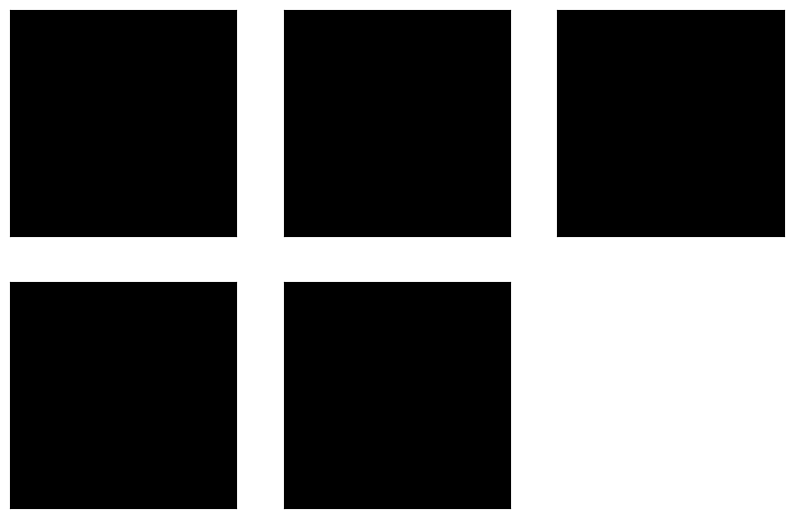

C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 498ms/step - accuracy: 0.7522 - loss: 0.6842 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 482ms/step - accuracy: 0.7356 - loss: 0.6546 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 480ms/step - accuracy: 0.7459 - loss: 0.6284 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 481ms/step - accuracy: 0.7373 - loss: 0.6139 - learning_rate: 0.0010
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 483ms/step - accuracy: 0.7428 - loss: 0.5985 - learning_rate: 0.0010
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 85s 511ms/step - accuracy: 0.7406 - loss: 0.5903 - learning_rate: 0.0010
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 538ms/step - accuracy: 0.7503 - loss: 0.5773 - learning_rate: 0.0010
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 530ms/step - accuracy: 0.7510 - loss: 0.5718 - learning_rate: 0.0010
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 528ms/step - accuracy: 0.7452 - loss: 0.5732 - learning_rate: 0

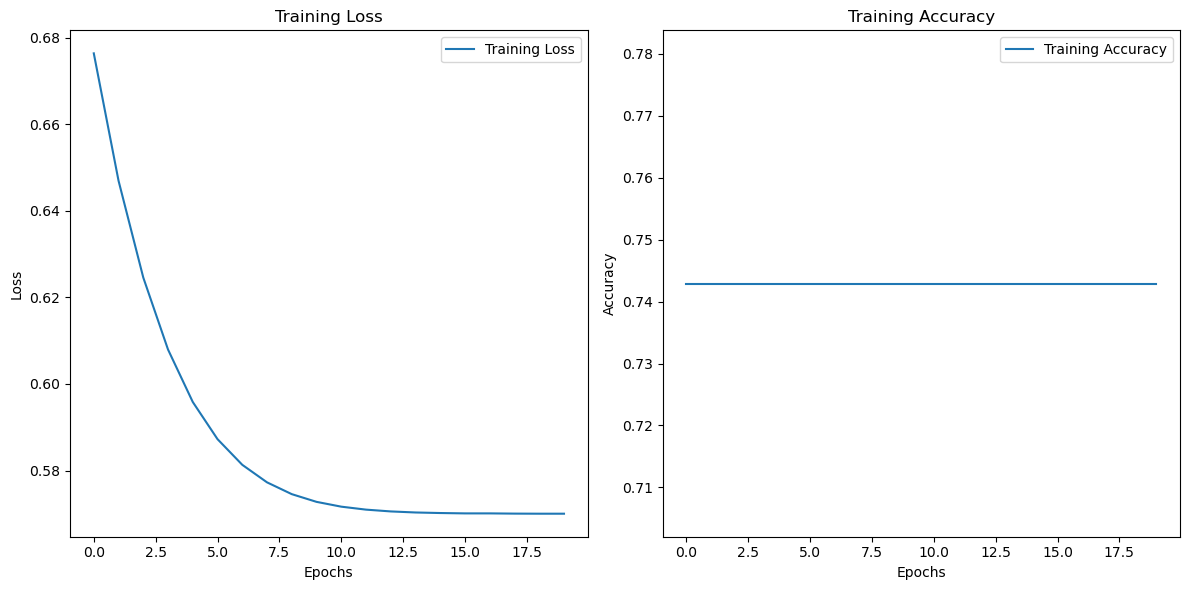

Augmentation de contraste et évaluation du modèle complétées.


In [9]:
# Import des bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Définir les constantes
img_size = 150
data_dir1 = '../../../chest_xray/train/PNEUMONIA'
data_dir2 = '../../../chest_xray/train/NORMAL'

# Fonction pour charger les données
def load_data(data_dir1, data_dir2):
    data = []
    
    # Charger les données pour la classe PNEUMONIA
    for img in os.listdir(data_dir1):
        try:
            img_arr = cv2.imread(os.path.join(data_dir1, img), cv2.IMREAD_GRAYSCALE)
            if img_arr is None:
                print(f"Failed to read {img}. Skipping.")
                continue
            resized_arr = cv2.resize(img_arr, (img_size, img_size))
            data.append([resized_arr, 0])  # 0 représente la classe PNEUMONIA
        except Exception as e:
            print(e)
    
    # Charger les données pour la classe NORMAL
    for img in os.listdir(data_dir2):
        try:
            img_arr = cv2.imread(os.path.join(data_dir2, img), cv2.IMREAD_GRAYSCALE)
            if img_arr is None:
                print(f"Failed to read {img}. Skipping.")
                continue
            resized_arr = cv2.resize(img_arr, (img_size, img_size))
            data.append([resized_arr, 1])  # 1 représente la classe NORMAL
        except Exception as e:
            print(e)
    
    return np.array(data, dtype=object)

# Charger les données d'entraînement
train_data = load_data(data_dir1, data_dir2)

# Séparer les features et les labels
def separate_features_labels(data):
    features, labels = [], []
    for feature, label in data:
        features.append(feature)
        labels.append(label)
    return np.array(features), np.array(labels)

# Obtenir les features et labels
x_train, y_train = separate_features_labels(train_data)

# Normaliser les données
x_train = x_train / 255.0
x_train = x_train.reshape(-1, img_size, img_size, 1)

# Assurer que les données ne sont pas vides
if x_train.size == 0 or y_train.size == 0:
    print("Les données d'entraînement sont vides. Veuillez vérifier le processus de chargement des données.")
else:
    # Data augmentation - contraste
    datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        brightness_range=[0.4, 0.8],  # Plage de luminosité ajustée pour un contraste modéré
        rotation_range=15,            # Rotation des images
        width_shift_range=0.1,        # Translation horizontale
        height_shift_range=0.1,       # Translation verticale
        zoom_range=0.2                # Zoom
    )

    datagen.fit(x_train)

    # Afficher quelques images augmentées
    def display_augmented_images(datagen, x_train, y_train):
        plt.figure(figsize=(10, 10))
        for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=5):
            for i in range(5):
                plt.subplot(330 + 1 + i)
                plt.xticks([])
                plt.yticks([])
                plt.imshow(x_batch[i].reshape(img_size, img_size), cmap='gray')
            plt.show()  # Afficher la figure complète après chaque lot
            break  # Sortir de la boucle après avoir affiché un seul lot

    # Afficher les images augmentées
    display_augmented_images(datagen, x_train, y_train)

    # Modèle amélioré pour l'entraînement
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),  # Ajout de Dropout pour régularisation
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),  # Ajout de Dropout pour régularisation
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),  # Ajout de Dropout pour régularisation
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks pour ajuster le taux d'apprentissage et stopper l'entraînement en cas de stagnation
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, min_lr=0.001)
    early_stop = EarlyStopping(monitor='loss', patience=3)

    # Entraîner le modèle avec les données augmentées
    history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=20, callbacks=[reduce_lr, early_stop])

    # Afficher les courbes de performance
    def plot_learning_curves(history):
        plt.figure(figsize=(12, 6))

        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()

        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    # Afficher les courbes d'apprentissage
    plot_learning_curves(history)

    print("Augmentation de contraste et évaluation du modèle complétées.")